In [1]:
from random import randrange
import pandas as pd
import numpy as np
import altair as alt
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1

## Carregando os dados - MNIST
Descrição do site de onde os dados são baixados:

"The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples"

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
print("Tamanho do vetor de dados:", mnist.data.shape)
print("Tamanho do vetor de alvos:", mnist.target.shape)

Tamanho do vetor de dados: (70000, 784)
Tamanho do vetor de alvos: (70000,)


### Separando o conjunto de treino e teste

- Vale ressaltar que o ideal, para garantir a generalização do modelo, é separar o conjunto de treinamento em "K folds", realizando uma validação cruzada. Para diminuir o tempo de execução e simplificar este tutorial, dividiremos apenas em 2 folds
- Além disso, o K-means pode ser sensível à inicialização aleatória dos clusters ou até mesmo da ordem em que os dados são apresentados para o algoritmo. Deste modo, uma boa prática seria executar o algoritmo algumas vezes variando ambas as condições, calcular a média dos centróides encontrados e, por fim, usar esta média como os centróides iniciais da última execução
- O conjunto de teste (últimas 10000 entradas), segundo a fonte, foi gerado de maneira independente do conjunto de treino

In [5]:
n_train_samples = 10000
n_test_samples = 1000

In [6]:
X_train = mnist.data[0:n_train_samples]
y_train = mnist.target[0:n_train_samples]

X_test = mnist.data[60000:60000 + n_test_samples]
y_test = mnist.target[60000:60000 + n_test_samples]
y_test_int = y_test.astype(int)

## Visualização de dados
### Selecionando uma amostra aleatória

In [7]:
def plot_digit(data, label = None):
    img = data.reshape(28,28)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation="nearest")
    if label is not None:
        plt.title("Label: %s" %label)
    plt.axis('off')

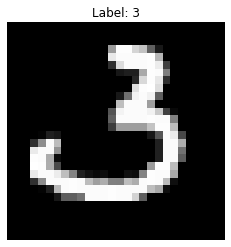

In [8]:
select = randrange(n_train_samples)
label = y_train[select]

plot_digit(X_train[select], label)

## K-means - 10 clusters

In [9]:
n_clusters = 10
kmeans_10 = KMeans(n_clusters=n_clusters).fit(X_train)

In [10]:
predicted_labels_10 = kmeans_10.predict(X_test)

## Visualizando os centróides

In [11]:
cluster_centers_10 = kmeans_10.cluster_centers_

### Definindo a label de cada um dos clusters
- Vamos descobrir qual é o dígito predominante em cada um dos clusters para entender se o K-means foi capaz de separar bem cada um dos dígitos em um cluster

Documentação:

numpy.bincount -> Count number of occurrences of each value in array of non-negative ints.

In [12]:
def get_most_freq_digit(real_labels, predicted_labels, n_clusters):
    #criando uma lista com todos os IDs de clusters que foram previstos no conjunto de teste
    id_clusters = np.unique(predicted_labels)
    
    most_freq = np.zeros(n_clusters) #inicializando o vetor que conterá os dígitos mais frequentes em cada cluster
    for icluster in range(n_clusters):
        #selecionando as labels das entradas que foram previstas como icluster
        labels = real_labels[predicted_labels==id_clusters[icluster]]
        
        #selecionando qual a label foi mais frequente para este cluster (icluster)
        most_freq[icluster] = np.argmax(np.bincount(labels))
    
    return most_freq

In [13]:
most_freq_10 = get_most_freq_digit(y_test_int, predicted_labels_10, n_clusters=10)

In [14]:
print(most_freq_10)

[1. 4. 1. 0. 7. 8. 3. 7. 2. 6.]


### Plotando o vetor que representa o centróide de cada cluster 

Text(0.5, 0.75, 'Cluster Centers')

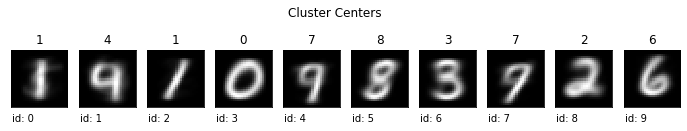

In [15]:
nrows = 1
ncols = n_clusters
irow = 0
icolumn = 0

fig, ax = plt.subplots(figsize=(12,4), nrows=nrows, ncols=ncols)

for cluster in range(n_clusters):
    img = cluster_centers_10[cluster];
    img = img.reshape(28,28)
    
    ax[icolumn].imshow(img, cmap='gray', interpolation="nearest")
    ax[icolumn].set_title(str(int(most_freq_10[cluster])))
    ax[icolumn].text(0, 35, 'id: %s' %cluster)
    
    ax[icolumn].get_xaxis().set_visible(False)
    ax[icolumn].get_yaxis().set_visible(False)
    
    icolumn += 1

plt.suptitle('Cluster Centers', y = 0.75)

## Visualização dos resultados - tSNE + altair

In [16]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.063s...
[t-SNE] Computed neighbors for 1000 samples in 1.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 502.251680
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.937874
[t-SNE] KL divergence after 1000 iterations: 1.067658


In [17]:
df_10 = pd.DataFrame()
df_10['tsne-2d-one'] = tsne_results[:,0]
df_10['tsne-2d-two'] = tsne_results[:,1]
df_10['label'] = y_test_int
df_10['cluster_id'] = predicted_labels_10
df_10['predicted'] = [int(most_freq_10[i]) for i in predicted_labels_10]
df_10['correct'] = df_10.apply(lambda x: x['predicted'] == x['label'], axis=1)

In [18]:
alt.Chart(df_10).mark_text().encode(
    text='label',
    x='tsne-2d-one',
    y='tsne-2d-two',
    color=alt.Color('predicted', type='nominal'),
    tooltip=['label', 'predicted']
).interactive()

alt.Chart(...)

## Aumentando o número de clusters para 20

In [19]:
n_clusters = 20
kmeans_20 = KMeans(n_clusters=n_clusters).fit(X_train)

In [20]:
predicted_labels_20 = kmeans_20.predict(X_test)

## Visualizando os centróides

In [21]:
cluster_centers_20 = kmeans_20.cluster_centers_

### Definindo a label de cada um dos clusters 
- Vamos descobrir qual é o dígito predominante em cada um dos clusters para entender se o K-means foi capaz de separar bem cada um dos dígitos em um cluster 

In [22]:
most_freq_20 = get_most_freq_digit(y_test_int, predicted_labels_20, n_clusters)

Text(0.5, 0.75, 'Cluster Centers')

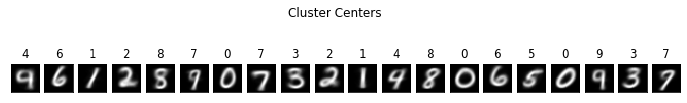

In [23]:
nrows = 1
ncols = n_clusters
irow = 0
icolumn = 0

fig, ax = plt.subplots(figsize=(12,4), nrows=nrows, ncols=ncols)

for cluster in range(n_clusters):
    img = cluster_centers_20[cluster];
    img = img.reshape(28,28)
    
    ax[icolumn].imshow(img, cmap='gray', interpolation="nearest")
    ax[icolumn].set_title("%s" %(int(most_freq_20[cluster])))
    
    ax[icolumn].get_xaxis().set_visible(False)
    ax[icolumn].get_yaxis().set_visible(False)
    
    icolumn += 1

plt.suptitle('Cluster Centers', y = 0.75)

## Visualização dos resultados para 20 clusters - tSNE + altair

In [24]:
df_20 = pd.DataFrame()
df_20['tsne-2d-one'] = tsne_results[:,0]
df_20['tsne-2d-two'] = tsne_results[:,1]
df_20['label'] = y_test_int
df_20['cluster_id'] = predicted_labels_20
df_20['predicted'] = [int(most_freq_20[i]) for i in predicted_labels_20]
df_20['correct'] = df_20.apply(lambda x: x['predicted'] == x['label'], axis=1)

In [25]:
alt.Chart(df_20).mark_text().encode(
    text='label',
    x='tsne-2d-one',
    y='tsne-2d-two',
    color=alt.Color('predicted', type='nominal'),
    tooltip=['label', 'predicted']
).interactive()

alt.Chart(...)

## Calcular métricas

### Dispersão intra cluster

In [26]:
kmeans_10.inertia_ > kmeans_20.inertia_

True

Há um decrescimento da distância intra cluster, aqui calculada com o método `inertia_`. 

Da documentação:
> Sum of squared distances of samples to their closest cluster center.

### Índice silhueta

In [27]:
silhouette_10 = silhouette_score(X_test, predicted_labels_10)
silhouette_20 = silhouette_score(X_test, predicted_labels_20)

In [28]:
silhouette_10 < silhouette_20

True

Há um crescimento do índice silhueta

## Cálculo de acurácia
- Apenas para fins didáticos, pois essa possibilidade não existiria para casos não supervisionados
- Assume-se que a label do cluster é a label da maioria dos dígitos neste cluster

In [29]:
def calculate_accuracy(y_true, y_pred, most_freq):
    """
    Parameters
    ----------
    y_true : array_like
             List of expected values
    y_pred : array_like
             List of predicted values
    most_freq: array_like
               List containing the most frequent(or the predominant) labels for each cluster ID
                
    Returns
    -------
    float
        Returns calculated accuracy
    """
    
    #most_freq contém os dígitos mais frequentes em cada cluster
    count = 0
    for ievent in range(len(y_true)):
        cluster_predict = y_pred[ievent].astype(int) #predição
        if int(y_true[ievent]) == int(most_freq[cluster_predict]):
            count += 1
    accuracy = count/float(len(y_true))
    return accuracy

In [30]:
calculate_accuracy(y_test_int, predicted_labels_10, most_freq_10)

0.557

In [31]:
calculate_accuracy(y_test_int, predicted_labels_20, most_freq_20)

0.687

Para 20 clusters, o K-means apresenta uma acurácia maior

## Outras figuras de mérito

### Davies-Bouldin index

In [32]:
db_10 = davies_bouldin_score(X_test, predicted_labels_10)
db_20 = davies_bouldin_score(X_test, predicted_labels_20)

In [33]:
db_20 < db_10

True

### Distância extra cluster

In [34]:
def mean_inter_cluster_dist(cluster_centers, data, predict):
    mean_data = np.mean(data)
    n_clusters = np.shape(cluster_centers)[0]
    f_out = 0
    
    for k in range(n_clusters):
        squared_norm_diff = np.linalg.norm(cluster_centers[k]-mean_data, ord=2)**2
        n_members = float(sum(predict==k))
        f_out += n_members*squared_norm_diff
    
    return f_out

In [35]:
ec_dist_10 = mean_inter_cluster_dist(cluster_centers_10, X_test, predicted_labels_10)
ec_dist_20 = mean_inter_cluster_dist(cluster_centers_20, X_test, predicted_labels_20)

In [36]:
ec_dist_20 > ec_dist_10

True

## Variando o número de clusters

In [37]:
max_train_samples = 1000
X_train_small = X_train[0:max_train_samples]
y_train_small = y_train[0:max_train_samples]

In [38]:
min_clusters = 10
max_clusters = 40

intra_cluster = np.zeros([max_clusters,1])
f_out = np.zeros([max_clusters,1])
silhouette = np.zeros([max_clusters,1])
DB_index = np.zeros([max_clusters,1])

output_train = np.zeros((max_clusters, X_train_small.shape[0]))
output_test = np.zeros((max_clusters, n_test_samples))
accuracy_train = np.zeros((max_clusters,))
accuracy_test = np.zeros((max_clusters,))

def run_kmeans(i):
    kmeans = KMeans(n_clusters=i).fit(X_train_small)
    output_train[i] = kmeans.predict(X_train_small)
    output_test[i] = kmeans.predict(X_test)
    
    most_freq = np.zeros(i)
    for icluster in range(i):
        id_clusters = np.unique(output_train[i])
        labels = y_train_small[output_train[i]==id_clusters[icluster]]
        
        most_freq[icluster] = np.argmax(np.bincount(labels.astype(int)))
        
        accuracy_train[i] = calculate_accuracy(y_train_small, output_train[i], most_freq)
        accuracy_test[i] = calculate_accuracy(y_test, output_test[i], most_freq)
        
        silhouette[i] = silhouette_score(X_test, output_test[i])
    
        #intra-cluster distance - dispersao intra classe 
        intra_cluster[i] = kmeans.inertia_

        #mean inter-cluster distance - dispersao media extra classe
        cluster_centers = kmeans.cluster_centers_
        f_out[i] = mean_inter_cluster_dist(cluster_centers, X_test, output_test[i])

        #Davies-Bouldin Index
        #Dkj = (dk +dj)/dkj
        DB_index[i] = davies_bouldin_score(X_test, output_test[i])

In [39]:
from joblib import Parallel, delayed

Parallel(n_jobs=4, backend="threading")(delayed(run_kmeans)(n_clusters) for n_clusters in range(min_clusters, max_clusters));

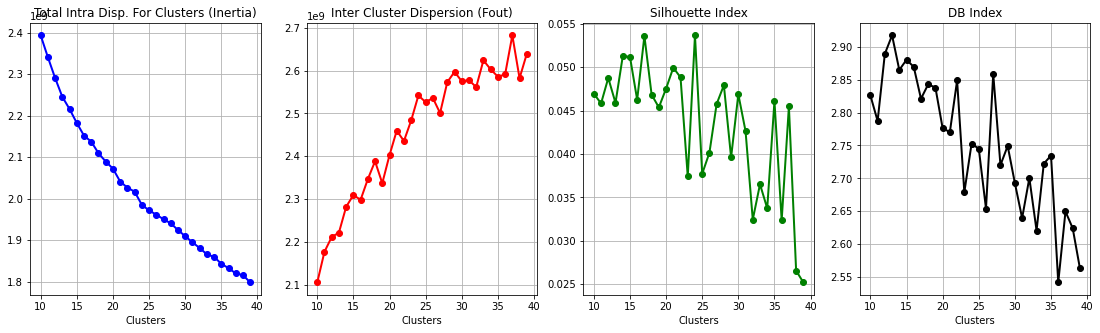

In [40]:
fig, ax = plt.subplots(figsize=(19,5),nrows=1, ncols=4)

ax[0].plot(range(min_clusters,max_clusters),intra_cluster[min_clusters:max_clusters,],'bo-')
ax[0].set_title("Total Intra Disp. For Clusters (Inertia)")
ax[0].set_xlabel('Clusters')
ax[0].grid()

ax[1].plot(range(min_clusters,max_clusters),f_out[min_clusters:max_clusters,],'ro-' ) #plot in the same graph as intra-cluster dispersion?
ax[1].set_title("Inter Cluster Dispersion (Fout)")
ax[1].set_xlabel('Clusters')
ax[1].grid()

ax[2].plot(range(min_clusters,max_clusters),silhouette[min_clusters:max_clusters,],'go-')
ax[2].set_title("Silhouette Index")
ax[2].set_xlabel('Clusters')
ax[2].grid()

ax[3].plot(range(min_clusters,max_clusters),DB_index[min_clusters:max_clusters,],'ko-')
ax[3].set_title("DB Index")
ax[3].set_xlabel('Clusters')
ax[3].grid()